# P4 - Optimizers

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

# Neural Networks in PyTorch

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # this ensures that the mean pixel value is 0 and the standard deviation is 1
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
# Set random seed for reproducibility
torch.manual_seed(302); np.random.seed(302)

# create validation split
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [4]:
class NeuralNet(nn.Module):
    def __init__(self):
      super(NeuralNet, self).__init__()
      self.fc1 = nn.Linear(in_features=28*28, out_features=128) 
      self.fc2 = nn.Linear(in_features=128, out_features=128)
      self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):
      # Flatten the data (B, 1, 28, 28) => (B, 784), where B is the batch size
      x = torch.flatten(x, start_dim=1)

      # Pass data through 1st fully connected layer
      x = self.fc1(x)
      # Apply ReLU non-linearity
      x = F.relu(x)

      # Pass data through 2nd fully connected layer
      x = self.fc2(x)
      # Apply ReLU non-linearity
      x = F.relu(x)

      # Pass data through 3rd fully connected layer
      x = self.fc3(x)

      # Before passing x to the (log) softmax function,
      # the values in x are called *logits*.

      # Apply softmax to x (in log domain)
      log_probs = F.log_softmax(x, dim=1)

      return log_probs

## Training the model

In [5]:
def train_model(model, optimizer, train_loader, val_loader, device, num_epochs=5):
    loss_fn = nn.NLLLoss()
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        print('-'*20, f'Epoch {epoch}', '-'*20)
        # Train one epoch
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            log_probs = model(data)
            loss = loss_fn(log_probs, target)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        print(f'Train Epoch {epoch} | Average Training Loss {np.mean(train_losses[-len(train_loader):])}')
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                log_probs = model(data)
                val_loss += F.nll_loss(log_probs, target, reduction='sum').item()  # sum up batch loss
                pred = torch.argmax(log_probs, dim=1)  # get the index of the max log-probability
                correct += (pred == target).sum().item()

        val_loss /= len(val_loader.dataset)
        avg_correct = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(avg_correct)

        print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * avg_correct:.0f}%)\n')
    
    return train_losses, val_losses, val_accuracies

## Naive comparison of different optimizers

In [6]:
# Source: https://gist.github.com/EmilienDupont/aaf429be5705b219aaaf8d691e27ca87
!chromium ./viz.html

Gtk-Message: 10:20:52.042: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[126689:126689:1112/102053.103990:ERROR:dbus/object_proxy.cc:573] Failed to call method: org.gnome.Mutter.IdleMonitor.AddIdleWatch: object_path= /org/gnome/Mutter/IdleMonitor/Core: org.freedesktop.DBus.Error.AccessDenied: An AppArmor policy prevents this sender from sending this message to this recipient; type="method_call", sender=":1.293" (uid=1000 pid=126689 comm="/snap/chromium/3265/usr/lib/chromium-browser/chrom" label="snap.chromium.chromium (enforce)") interface="org.gnome.Mutter.IdleMonitor" member="AddIdleWatch" error name="(unset)" requested_reply="0" destination="org.gnome.Mutter.IdleMonitor" (uid=1000 pid=2922 comm="/usr/bin/gnome-shell " label="unconfined")
[126689:126836:1112/102055.306439:ERROR:google_apis/gcm/engine/registration_request.cc:291] Registration response error message: QUOTA_EXCEEDED


Let's train the model with different optimizers and compare their performance.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Optimizers
optimizers = {
    'SGD': lambda params: torch.optim.SGD(params, lr=0.01, momentum=0), 
    'SGD with Momentum': lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9), 
    'Nesterov SGD with Momentum': lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True), 
    'RMSProp': lambda params: torch.optim.RMSprop(params, lr=0.01), 
    'Adam': lambda params: torch.optim.Adam(params, lr=0.001)
}

val_accuracies_per_optimizer = {}

for optimizer_name, optimizer_init_fn in optimizers.items():
    model = NeuralNet().to(device)
    optimizer = optimizer_init_fn(model.parameters())

    print(f'Optimizer: {optimizer_name}')
    train_losses, val_losses, val_accuracies = train_model(model, optimizer, train_loader, val_loader, device, num_epochs=5)
    val_accuracies_per_optimizer[optimizer_name] = val_accuracies[-1] # save the last accuracy
    print('-'*50)

Optimizer: SGD
-------------------- Epoch 0 --------------------
Train Epoch 0 | Average Training Loss 0.856042930079848
Validation set: Average loss: 0.3664, Accuracy: 8972/10000 (90%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Average Training Loss 0.324282872250013
Validation set: Average loss: 0.2892, Accuracy: 9171/10000 (92%)

-------------------- Epoch 2 --------------------
Train Epoch 2 | Average Training Loss 0.2652391047238389
Validation set: Average loss: 0.2523, Accuracy: 9271/10000 (93%)

-------------------- Epoch 3 --------------------
Train Epoch 3 | Average Training Loss 0.227585169450973
Validation set: Average loss: 0.2184, Accuracy: 9376/10000 (94%)

-------------------- Epoch 4 --------------------
Train Epoch 4 | Average Training Loss 0.20055425566290042
Validation set: Average loss: 0.1993, Accuracy: 9423/10000 (94%)

--------------------------------------------------
Optimizer: SGD with Momentum
-------------------- Epoch 0 -------------

KeyboardInterrupt: 

Learning rate is a *crucial* hyperparameter to tune. It can have a significant impact on the training run and performance of the model:

In [8]:
model = NeuralNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # pick very large learning rate for demonstration
train_losses, val_losses, val_accuracies = train_model(model, optimizer, train_loader, val_loader, device, num_epochs=5)

-------------------- Epoch 0 --------------------
Train Epoch 0 | Average Training Loss 3.086304816443597
Validation set: Average loss: 2.3063, Accuracy: 1068/10000 (11%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Average Training Loss 2.4509991846426065
Validation set: Average loss: 2.3099, Accuracy: 1025/10000 (10%)

-------------------- Epoch 2 --------------------
Train Epoch 2 | Average Training Loss 2.3097194189305807
Validation set: Average loss: 2.3113, Accuracy: 981/10000 (10%)

-------------------- Epoch 3 --------------------
Train Epoch 3 | Average Training Loss 2.3096398160890543
Validation set: Average loss: 2.3152, Accuracy: 981/10000 (10%)

-------------------- Epoch 4 --------------------
Train Epoch 4 | Average Training Loss 2.3101379761610494
Validation set: Average loss: 2.3143, Accuracy: 996/10000 (10%)



# Plot Validation Accuracies

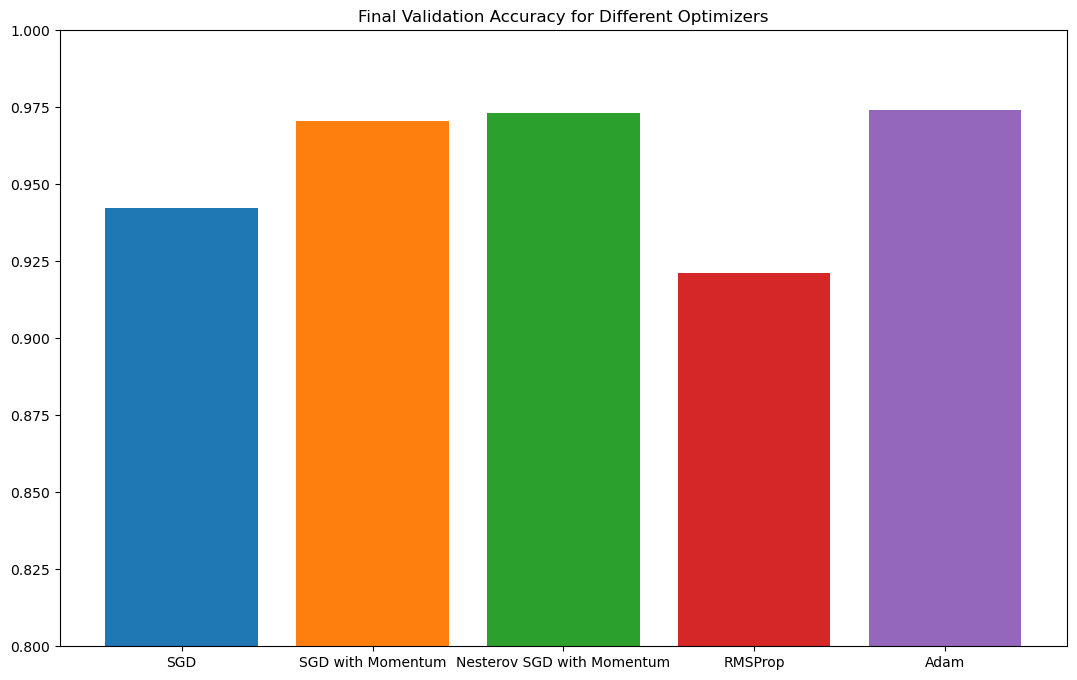

In [9]:
import matplotlib.colors as mcolors

opt_names, val_accs = val_accuracies_per_optimizer.keys(), val_accuracies_per_optimizer.values()

plt.figure(figsize=(13, 8))
plt.title('Final Validation Accuracy for Different Optimizers')
plt.bar(opt_names, val_accs, color=mcolors.TABLEAU_COLORS)
plt.ylim(0.8, 1.0)
plt.show()

# Learning Rate Schedules

Schedulers adjust the learning rate based on the number of epochs or other factors. 

In [10]:
def train_model_with_scheduler(model, optimizer, scheduler, train_loader, val_loader, device, num_epochs=5):
    loss_fn = nn.NLLLoss()
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        print('-'*20, f'Epoch {epoch}', '-'*20)
        # Train one epoch
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            log_probs = model(data)
            loss = loss_fn(log_probs, target)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
        
        scheduler.step() # update learning rate based on the schedule
        print(f'Train Epoch {epoch} | Average Training Loss {np.mean(train_losses[-len(train_loader):])} | Learning rate: {np.round(scheduler.get_last_lr()[0], 5)}')
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                log_probs = model(data)
                val_loss += F.nll_loss(log_probs, target, reduction='sum').item()  # sum up batch loss
                pred = torch.argmax(log_probs, dim=1)  # get the index of the max log-probability
                correct += (pred == target).sum().item()

        val_loss /= len(val_loader.dataset)
        avg_correct = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(avg_correct)

        print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * avg_correct:.0f}%)\n')
    
    return train_losses, val_losses, val_accuracies

In [11]:
def plot_scheduler_lr(name, scheduler, num_epochs=50):
    lrs = []
    for _ in range(num_epochs):
        lrs.append(scheduler.get_last_lr())
        scheduler.step()

    plt.title(name)
    plt.plot(lrs)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.show()

/home/simon/miniconda3/envs/deeplearning/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


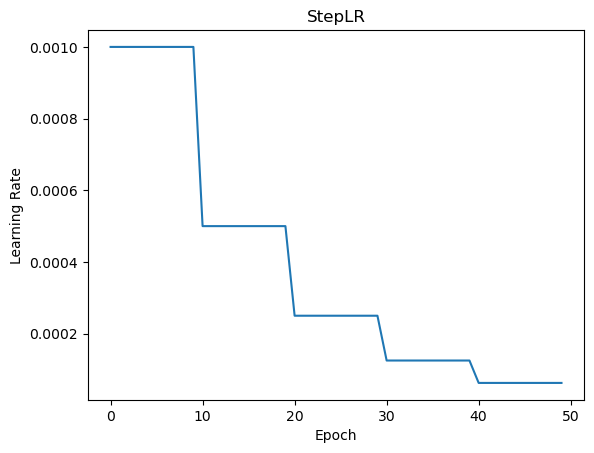

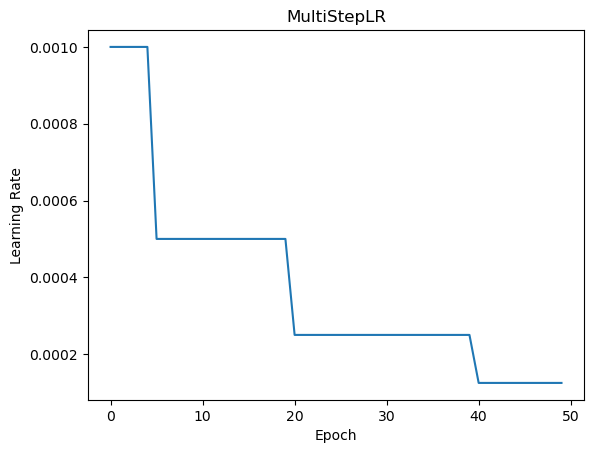

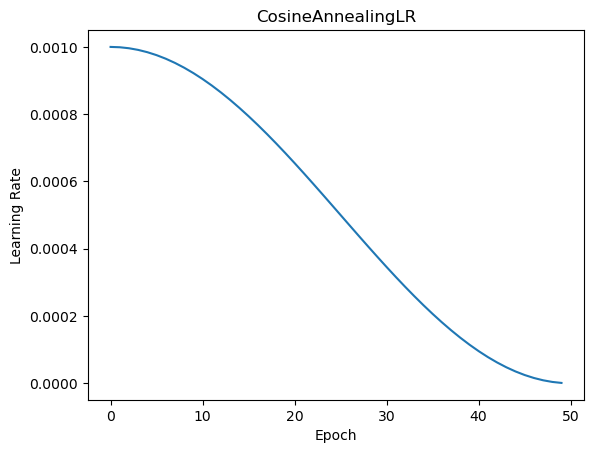

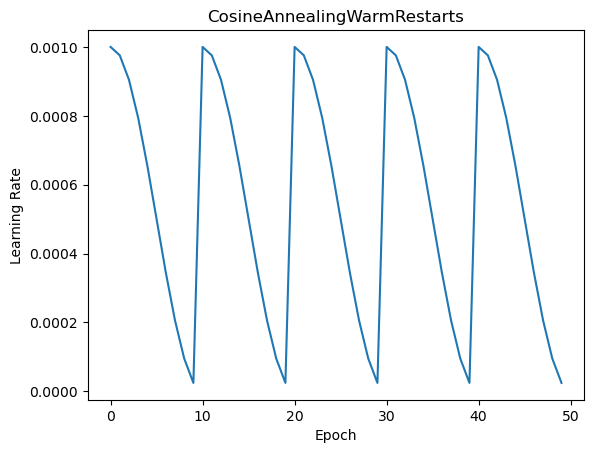

In [12]:
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NeuralNet().to(device)

schedulers = {
    'StepLR': lambda optimizer: StepLR(optimizer, step_size=10, gamma=0.5),
    'MultiStepLR': lambda optimizer: MultiStepLR(optimizer, milestones=[5, 20, 40], gamma=0.5),
    'CosineAnnealingLR': lambda optimizer: CosineAnnealingLR(optimizer, T_max=50),
    'CosineAnnealingWarmRestarts': lambda optimizer: CosineAnnealingWarmRestarts(optimizer, T_0=10),
}


for name, scheduler_int_fn in schedulers.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = scheduler_int_fn(optimizer)
    plot_scheduler_lr(name, scheduler)

Many more schedules are available in PyTorch, see [https://pytorch.org/docs/stable/optim.html](https://pytorch.org/docs/stable/optim.html).

In [13]:
model = NeuralNet().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0) # start with slightly larger learning rate and decay it
scheduler = StepLR(optimizer, step_size=1, gamma=0.9) # multiply lr by 0.9 every epoch

train_losses, val_losses, val_accuracies = train_model_with_scheduler(model, optimizer, scheduler, train_loader, val_loader, device, num_epochs=5)

-------------------- Epoch 0 --------------------
Train Epoch 0 | Average Training Loss 0.4156097840527287 | Learning rate: 0.045
Validation set: Average loss: 0.2133, Accuracy: 9335/10000 (93%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Average Training Loss 0.1700766871580878 | Learning rate: 0.0405
Validation set: Average loss: 0.1459, Accuracy: 9562/10000 (96%)

-------------------- Epoch 2 --------------------
Train Epoch 2 | Average Training Loss 0.12053835845511893 | Learning rate: 0.03645
Validation set: Average loss: 0.1378, Accuracy: 9578/10000 (96%)

-------------------- Epoch 3 --------------------
Train Epoch 3 | Average Training Loss 0.09429431983086345 | Learning rate: 0.03281
Validation set: Average loss: 0.1137, Accuracy: 9649/10000 (96%)

-------------------- Epoch 4 --------------------
Train Epoch 4 | Average Training Loss 0.07694131268850525 | Learning rate: 0.02952
Validation set: Average loss: 0.1017, Accuracy: 9688/10000 (97%)

